<a href="https://colab.research.google.com/github/DavidZhang88/Hawkes-Process-Toolkit/blob/master/Denoise_Autoencoder_for_tfsimu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import json
import numpy as np
data=json.load(open('/content/drive/My Drive/trfsim/all.json','r'))

x=np.array(data).T
x=x[1]

In [0]:
import numpy as np
xxx=np.zeros(shape=(x.shape[0],len(x[0])))

for i in range (x.shape[0]):
  xxx[i]=np.array(x[i])
xxx=np.transpose(xxx)

ssssum = xxx.sum(axis=1)

import os
path = "/content/drive/My Drive/Denoise_result"

os.chdir(path)
os.listdir(path)

np.savetxt('sumofeachsimulation.csv', ssssum, delimiter = ',')
paramtr = [np.mean(xxx),np.std(xxx)]
np.savetxt('meanandstd.csv', paramtr, delimiter = ',')
xxx= (xxx-np.mean(xxx))/(np.std(xxx))


In [4]:
lengthof = xxx.shape[0]# 33000
widthof = xxx.shape[1] # 2302

print(lengthof,widthof)

2302 35739


In [0]:
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
from torch.nn import init

widthof = xxx.shape[1]# 33000
lengthof = xxx.shape[0] # 2302


class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder = nn.Sequential(
                nn.Linear(widthof,8000),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(8000,2000),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(2000,500),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(500,125),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(125,50),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(50,25),
                nn.Dropout(0.5),
                nn.ReLU(),
                nn.Linear(25,10)
                )

        self.decoder = nn.Sequential(
                nn.Linear(10,25),
                nn.ReLU(),
                nn.Linear(25,50),
                nn.ReLU(),
                nn.Linear(50,125),
                nn.ReLU(),
                nn.Linear(125,500),
                nn.ReLU(),
                nn.Linear(500,2000),
                nn.ReLU(),
                nn.Linear(2000,8000),
                nn.ReLU(),
                nn.Linear(8000,widthof),
                nn.Tanh()
                )
    def forward(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode,decode


from torch.nn import init

def weigth_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_uniform(m.weight.data,nonlinearity='relu') #relu 不能用Xavier 得用kaiming
        init.constant_(m.bias.data,0.1)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
        init.kaiming_uniform(m.weight.data)
        init.constant_(m.bias.data,0.1)


In [6]:
num = np.random.permutation(xxx.shape[0])		#打乱后的行号
train_set = xxx[num,:]		#获取打乱后的训练数据
net = autoencoder().cuda()  
criterion = nn.MSELoss()

net.apply(weigth_init)
optimizer = torch.optim.SGD(net.parameters(),lr=0.08,momentum= 0.8, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.5, patience=20,
                                                       verbose=True,
                                                       threshold = 1e-5,                                                        
                                                       threshold_mode='rel',
                                                       cooldown=400, min_lr=0)

minibatch = 800
epoches = 500

for e in range(epoches):
  
  for i in range(0,lengthof,minibatch):
        input = train_set[i:i+minibatch]
        input = torch.tensor(input,dtype=torch.float32).cuda()             
        _, output = net(input)
        loss = criterion(output,input)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
  scheduler.step(loss)      
  if (e+1) %  1 == 0:
        print('After traing: epoch:{},Loss:{:.6f}'.format(e+1,loss.data));

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:68: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.


After traing: epoch:1,Loss:1.835307
After traing: epoch:2,Loss:1.657089
After traing: epoch:3,Loss:1.509222
After traing: epoch:4,Loss:1.370263
After traing: epoch:5,Loss:1.243574
After traing: epoch:6,Loss:1.127304
After traing: epoch:7,Loss:1.031976
After traing: epoch:8,Loss:0.958329
After traing: epoch:9,Loss:0.911707
After traing: epoch:10,Loss:0.880325
After traing: epoch:11,Loss:0.857451
After traing: epoch:12,Loss:0.837371
After traing: epoch:13,Loss:0.823708
After traing: epoch:14,Loss:0.809833
After traing: epoch:15,Loss:0.797716
After traing: epoch:16,Loss:0.786483
After traing: epoch:17,Loss:0.775644
After traing: epoch:18,Loss:0.766096
After traing: epoch:19,Loss:0.756715
After traing: epoch:20,Loss:0.748580
After traing: epoch:21,Loss:0.740644
After traing: epoch:22,Loss:0.732864
After traing: epoch:23,Loss:0.726028
After traing: epoch:24,Loss:0.719895
After traing: epoch:25,Loss:0.713961
After traing: epoch:26,Loss:0.708380
After traing: epoch:27,Loss:0.702610
After trai

In [0]:
net.eval()
enmat=np.zeros(shape=(xxx.shape[0],10))
for i in range(0,lengthof):
  input = train_set[i]
  input = torch.tensor(input,dtype=torch.float32).cuda()
               
  encode,out  = net(input)

  encode = encode.cpu()
  encode = encode.data.numpy()
  enmat[i] = encode

In [0]:

np.savetxt('enmat.csv', enmat, delimiter = ',')
np.savetxt('num.csv', num, delimiter = ',')

In [9]:
print(enmat[0])
print(enmat[2])

[ 0.27454013  0.14699656 -0.00190559  0.03379592  0.15829729  0.3949565
  0.10570361  0.10658454 -0.19020243  0.24885558]
[ 0.27112177  0.14654166 -0.00535967  0.0336926   0.16054386  0.39975768
  0.1095396   0.10303532 -0.19477533  0.2497872 ]


In [0]:
import numpy as np
#enmat = np.loadtxt(open("/content/drive/My Drive/result/enmat.csv"),delimiter=",",skiprows=0) 

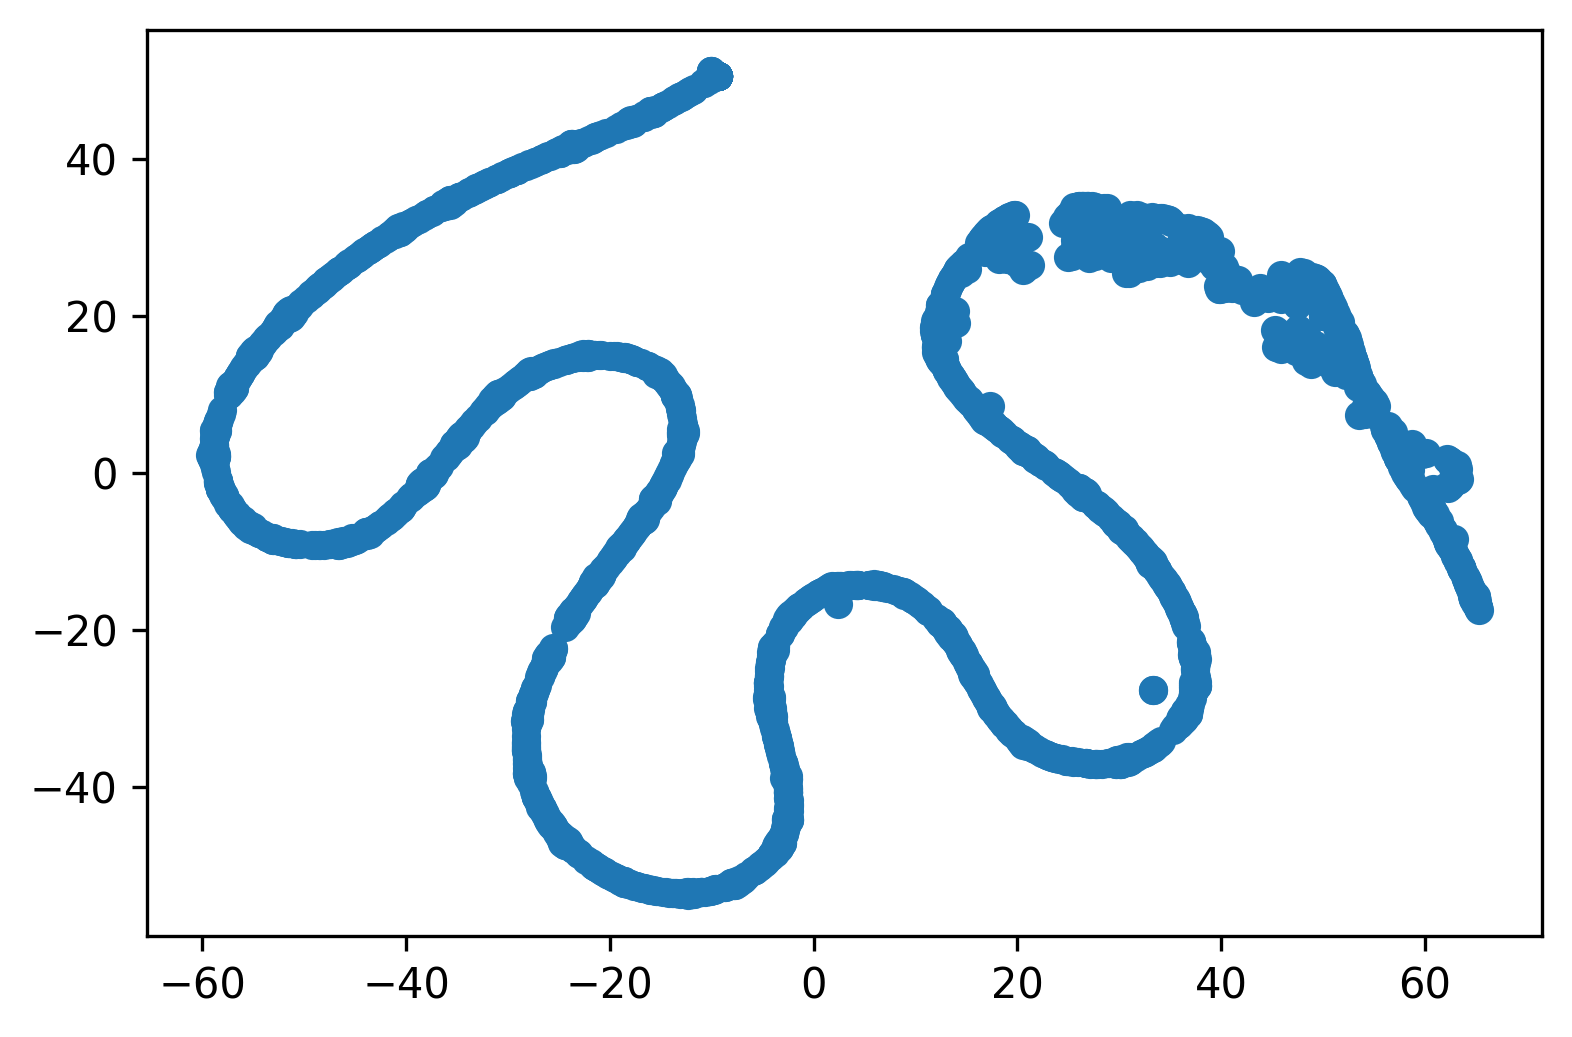

In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300
res=TSNE(n_components=2,init='pca').fit_transform(enmat)
plt.scatter(res[:,0],res[:,1]) 


11922.426348258823


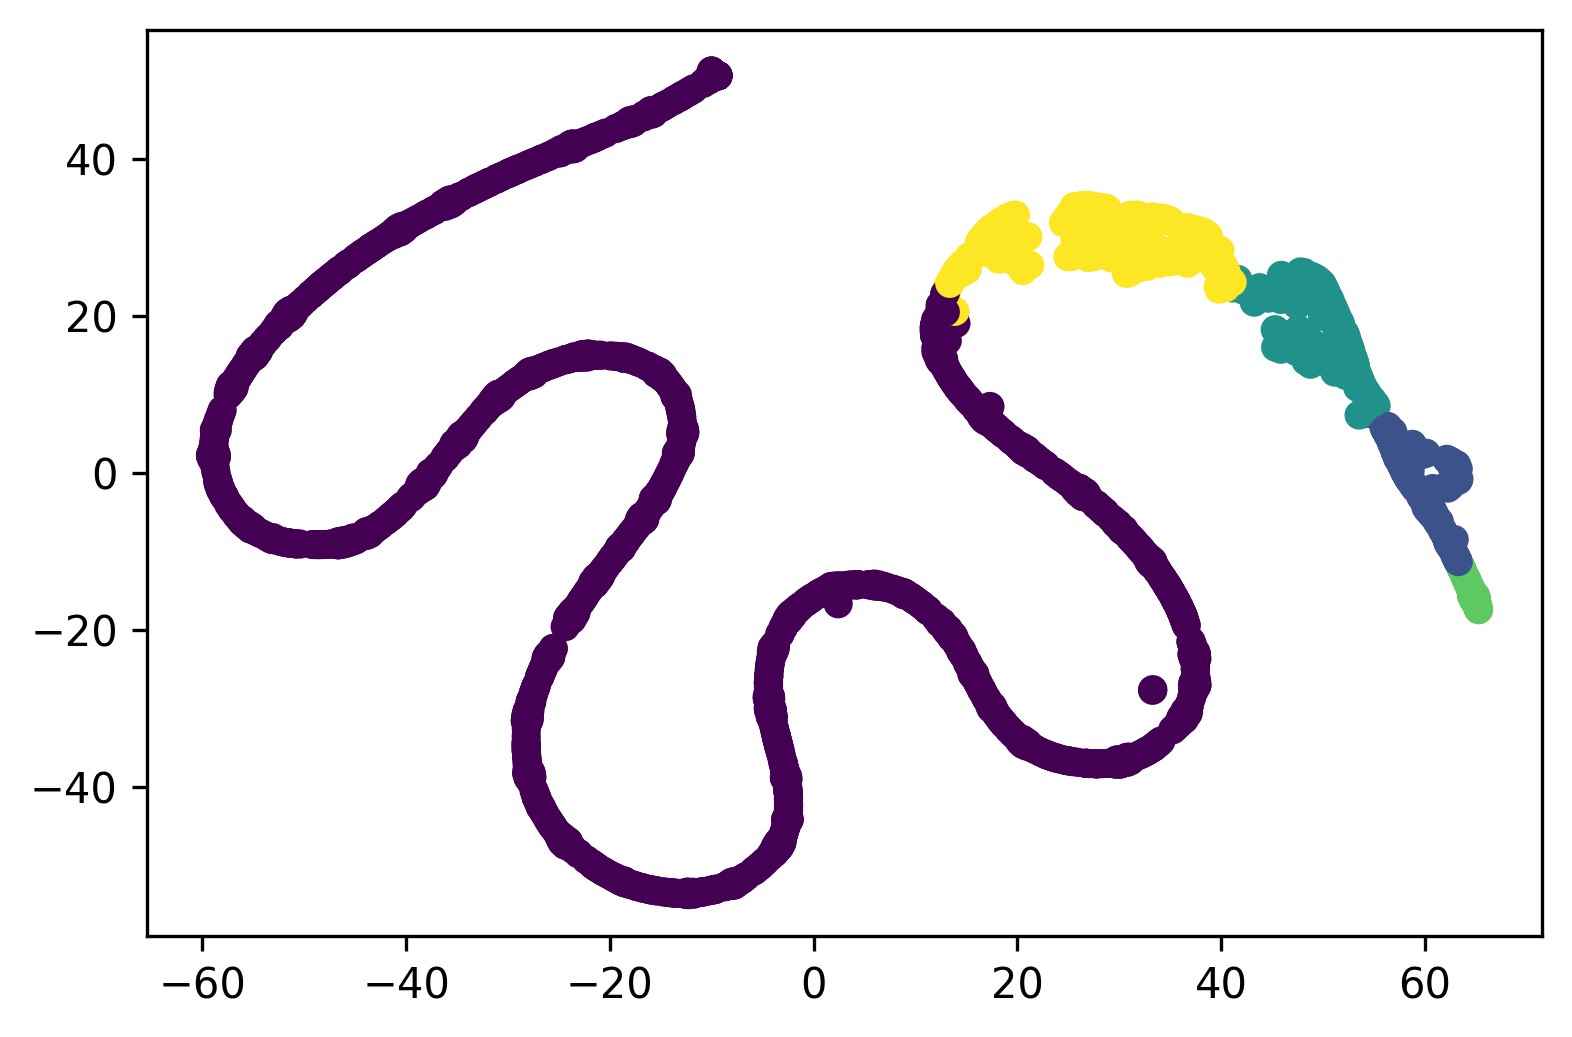

In [12]:
import numpy as np
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

y_pre = KMeans(n_clusters=5).fit_predict(enmat)
score = calinski_harabasz_score(enmat, y_pre)


plt.scatter(res[:,0],res[:,1],c=y_pre)
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300

np.savetxt('lrlabel.csv', y_pre, delimiter = ',')
print(score)

从图像中可以看到，车辆最少时，是蓝色，然后过渡到红色，最后过渡到黄色。


可以使用高斯核，对n_cluster 和 gamma 进行调参


```
start = time.clock()
best_score, best_k, best_gamma = 0,0,0
for gamma in (0.01, 0.1, 1, 5):
    for k in (3, 4, 5, 6):
        y_pre = SpectralClustering(n_clusters=k, gamma=gamma).fit_predict(enmat)
        score = calinski_harabasz_score(enmat, y_pre)
        print('calinski_harabasz_score: %.3f, k value: % d, gamma value: %f'%(calinski_harabasz_score(enmat, y_pre),
              k, gamma))
        if score > best_score:
            best_score = score
            best_k = k 
            best_gamma = gamma
              
print('best_score:%.3f, best_k: %d , best_gamma: %.3f'%(best_score, best_k, best_gamma))
```



In [0]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt

re3d=TSNE(n_components=3,init='pca').fit_transform(enmat)

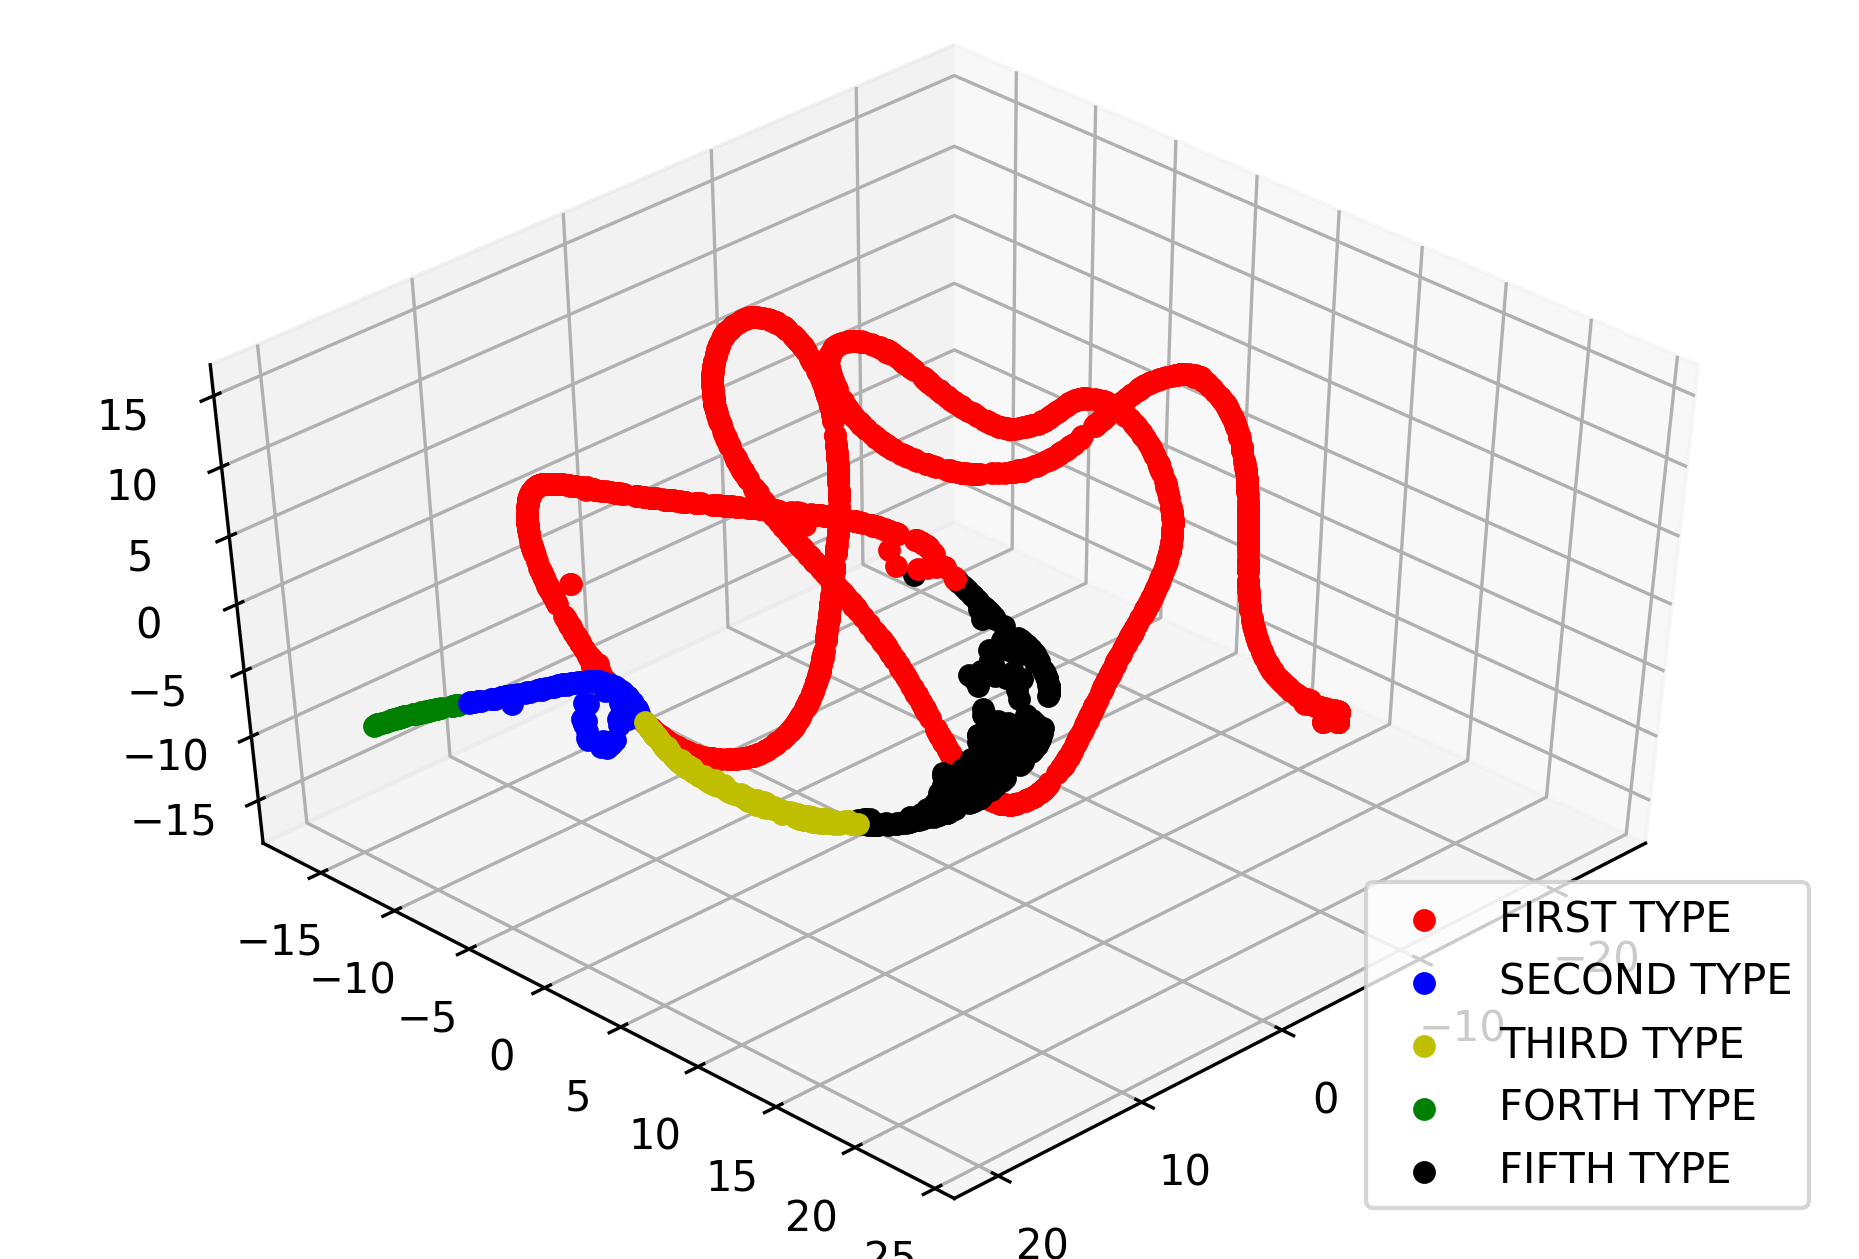

In [14]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import math
import matplotlib.pyplot as plt


# 此处fig是二维
fig = plt.figure()
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300
# 将二维转化为三维
axes3d = Axes3D(fig)
axes3d.view_init(elev=45,azim=45)

for i in range (y_pre.shape[0]):
  if y_pre[i] == 0:
    point1=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='r')
  if y_pre[i] == 1:
    point2=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='b')
  if y_pre[i] == 2:
    point3=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='y')
  if y_pre[i] == 3:
    point4=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='g')
  if y_pre[i] == 4:
    point5=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='#000000')

plt.legend([point1,point2, point3,point4,point5], ['FIRST TYPE','SECOND TYPE','THIRD TYPE','FORTH TYPE','FIFTH TYPE'], loc='lower right', scatterpoints=1)




绿红蓝黑黄 通畅 正常 略有拥堵 拥堵 十分拥堵

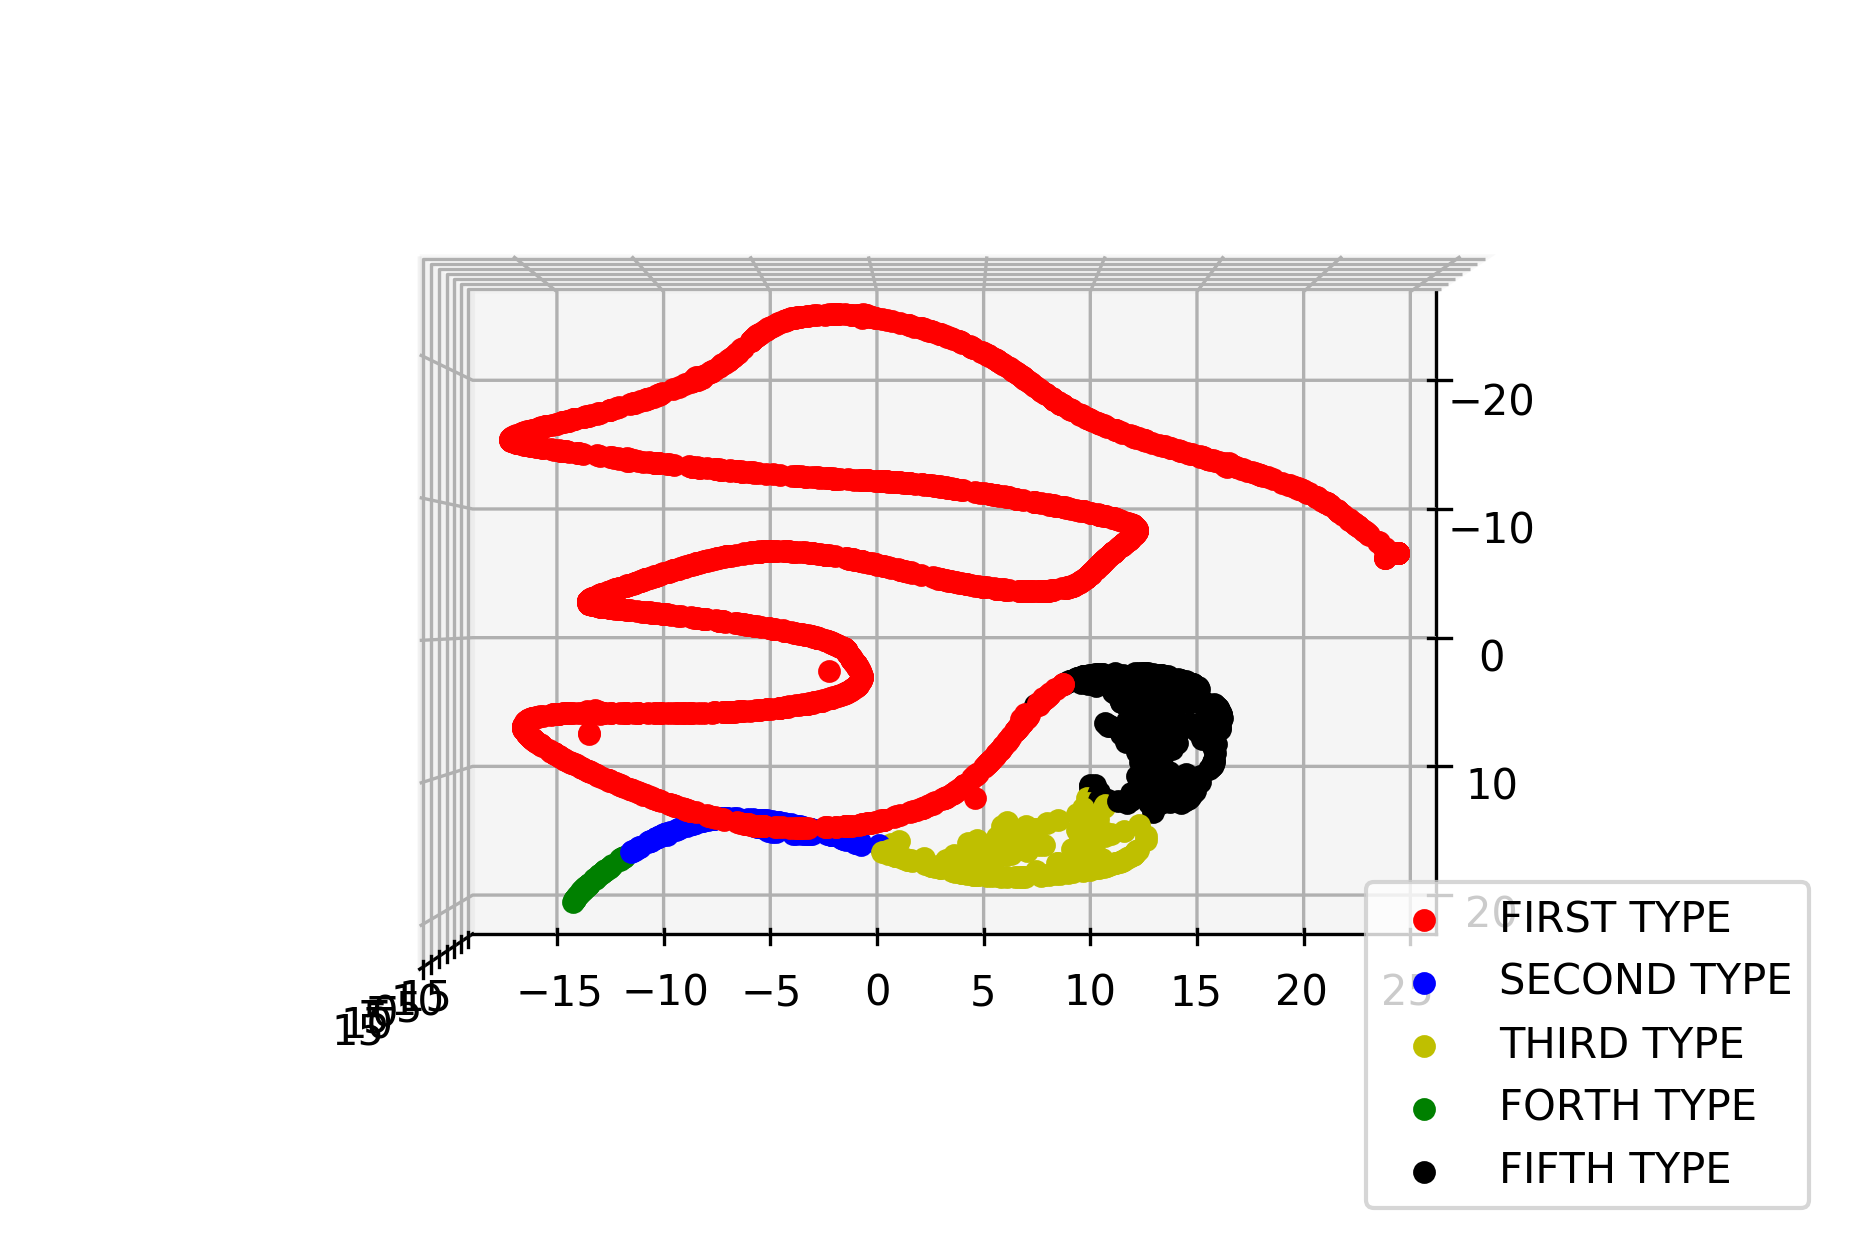

In [15]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import math
import matplotlib.pyplot as plt


# 此处fig是二维
fig = plt.figure()
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300
# 将二维转化为三维
axes3d = Axes3D(fig)
axes3d.view_init(elev=90,azim=0)

for i in range (y_pre.shape[0]):
  if y_pre[i] == 0:
    point1=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='r')
  if y_pre[i] == 1:
    point2=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='b')
  if y_pre[i] == 2:
    point3=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='y')
  if y_pre[i] == 3:
    point4=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='g')
  if y_pre[i] == 4:
    point5=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='#000000')

plt.legend([point1,point2, point3,point4,point5], ['FIRST TYPE','SECOND TYPE','THIRD TYPE','FORTH TYPE','FIFTH TYPE'], loc='lower right', scatterpoints=1)




绿红蓝黑黄 通畅 正常 略有拥堵 拥堵 十分拥堵

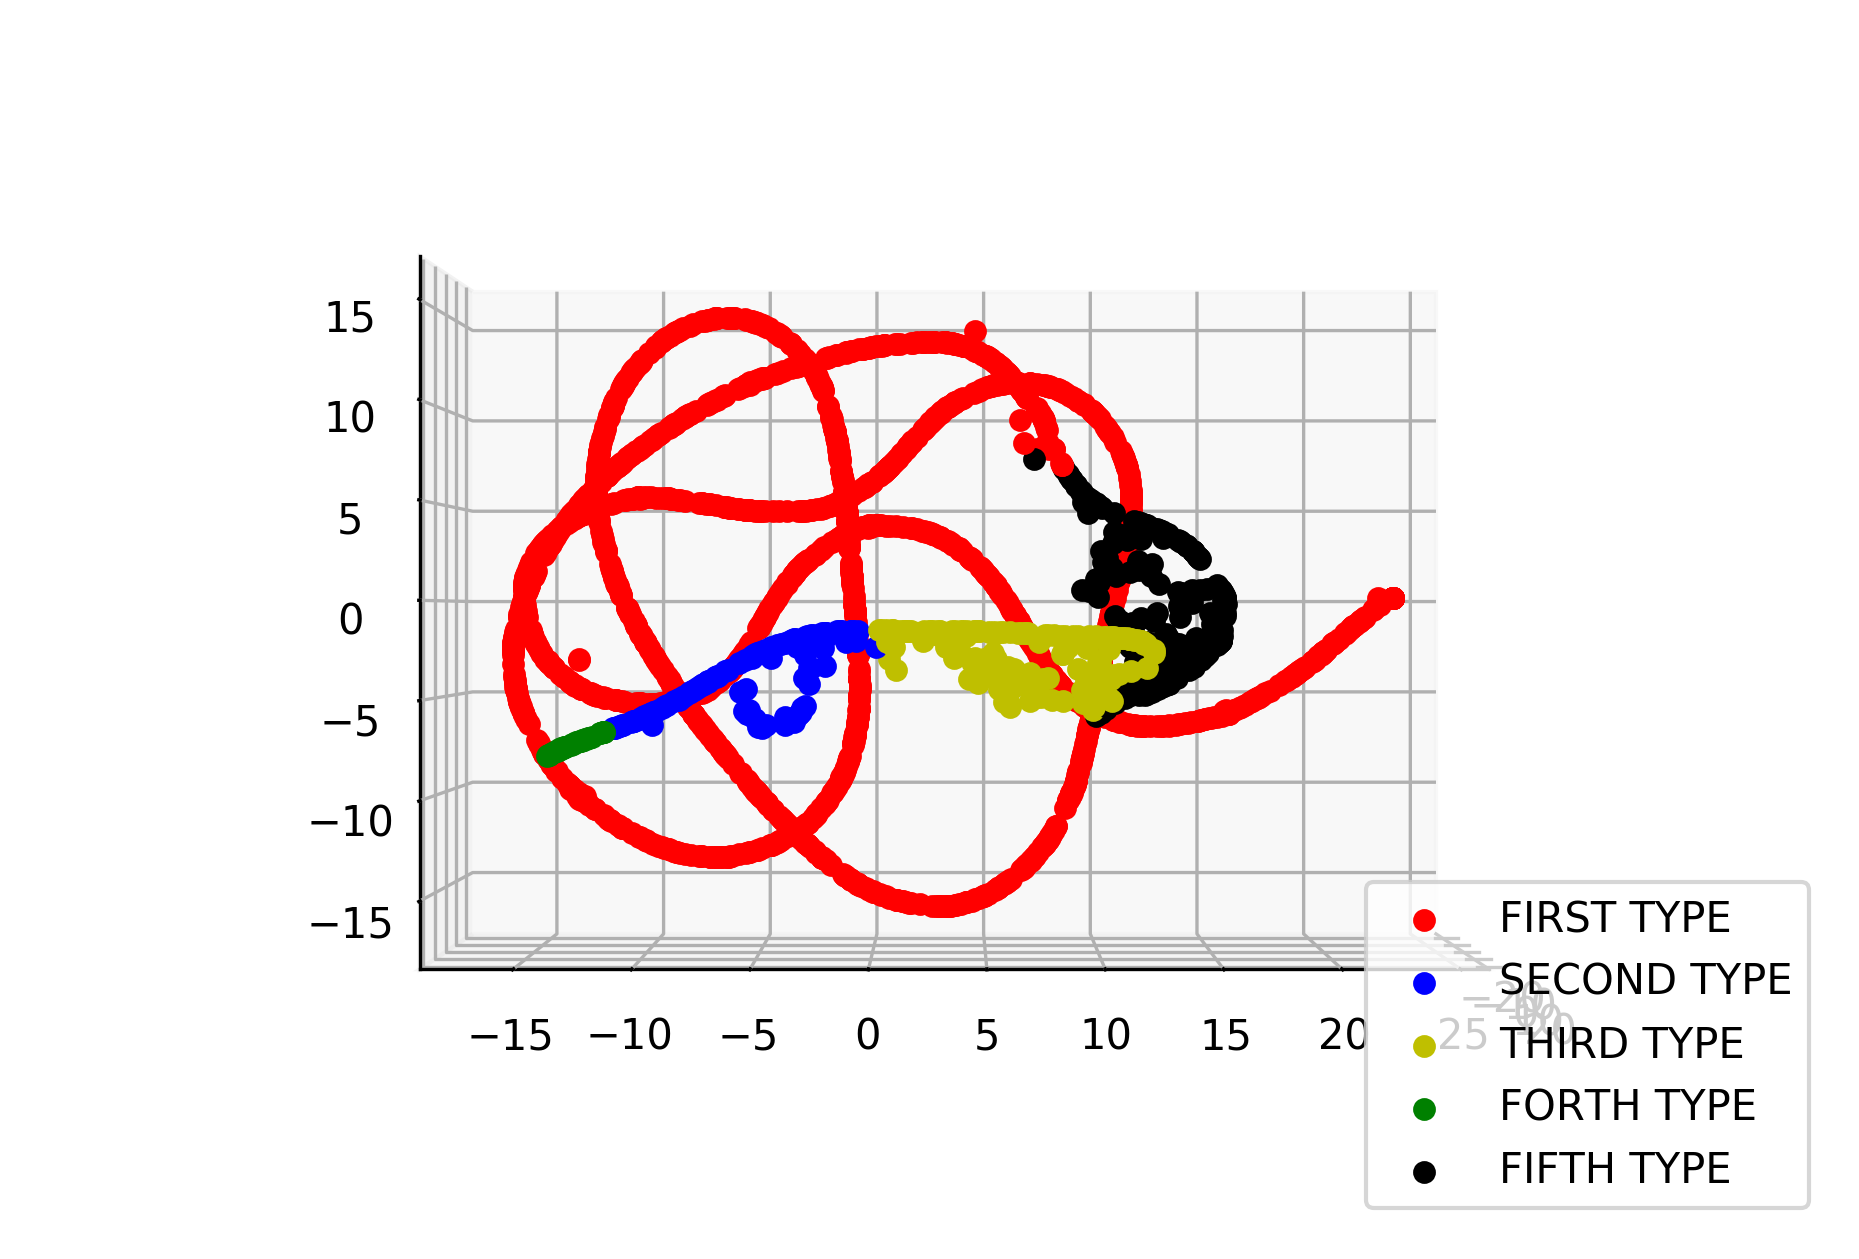

In [16]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import math
import matplotlib.pyplot as plt


# 此处fig是二维
fig = plt.figure()
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300
# 将二维转化为三维
axes3d = Axes3D(fig)
axes3d.view_init(elev=0,azim=0)

for i in range (y_pre.shape[0]):
  if y_pre[i] == 0:
    point1=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='r')
  if y_pre[i] == 1:
    point2=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='b')
  if y_pre[i] == 2:
    point3=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='y')
  if y_pre[i] == 3:
    point4=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='g')
  if y_pre[i] == 4:
    point5=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='#000000')

plt.legend([point1,point2, point3,point4,point5], ['FIRST TYPE','SECOND TYPE','THIRD TYPE','FORTH TYPE','FIFTH TYPE'], loc='lower right', scatterpoints=1)





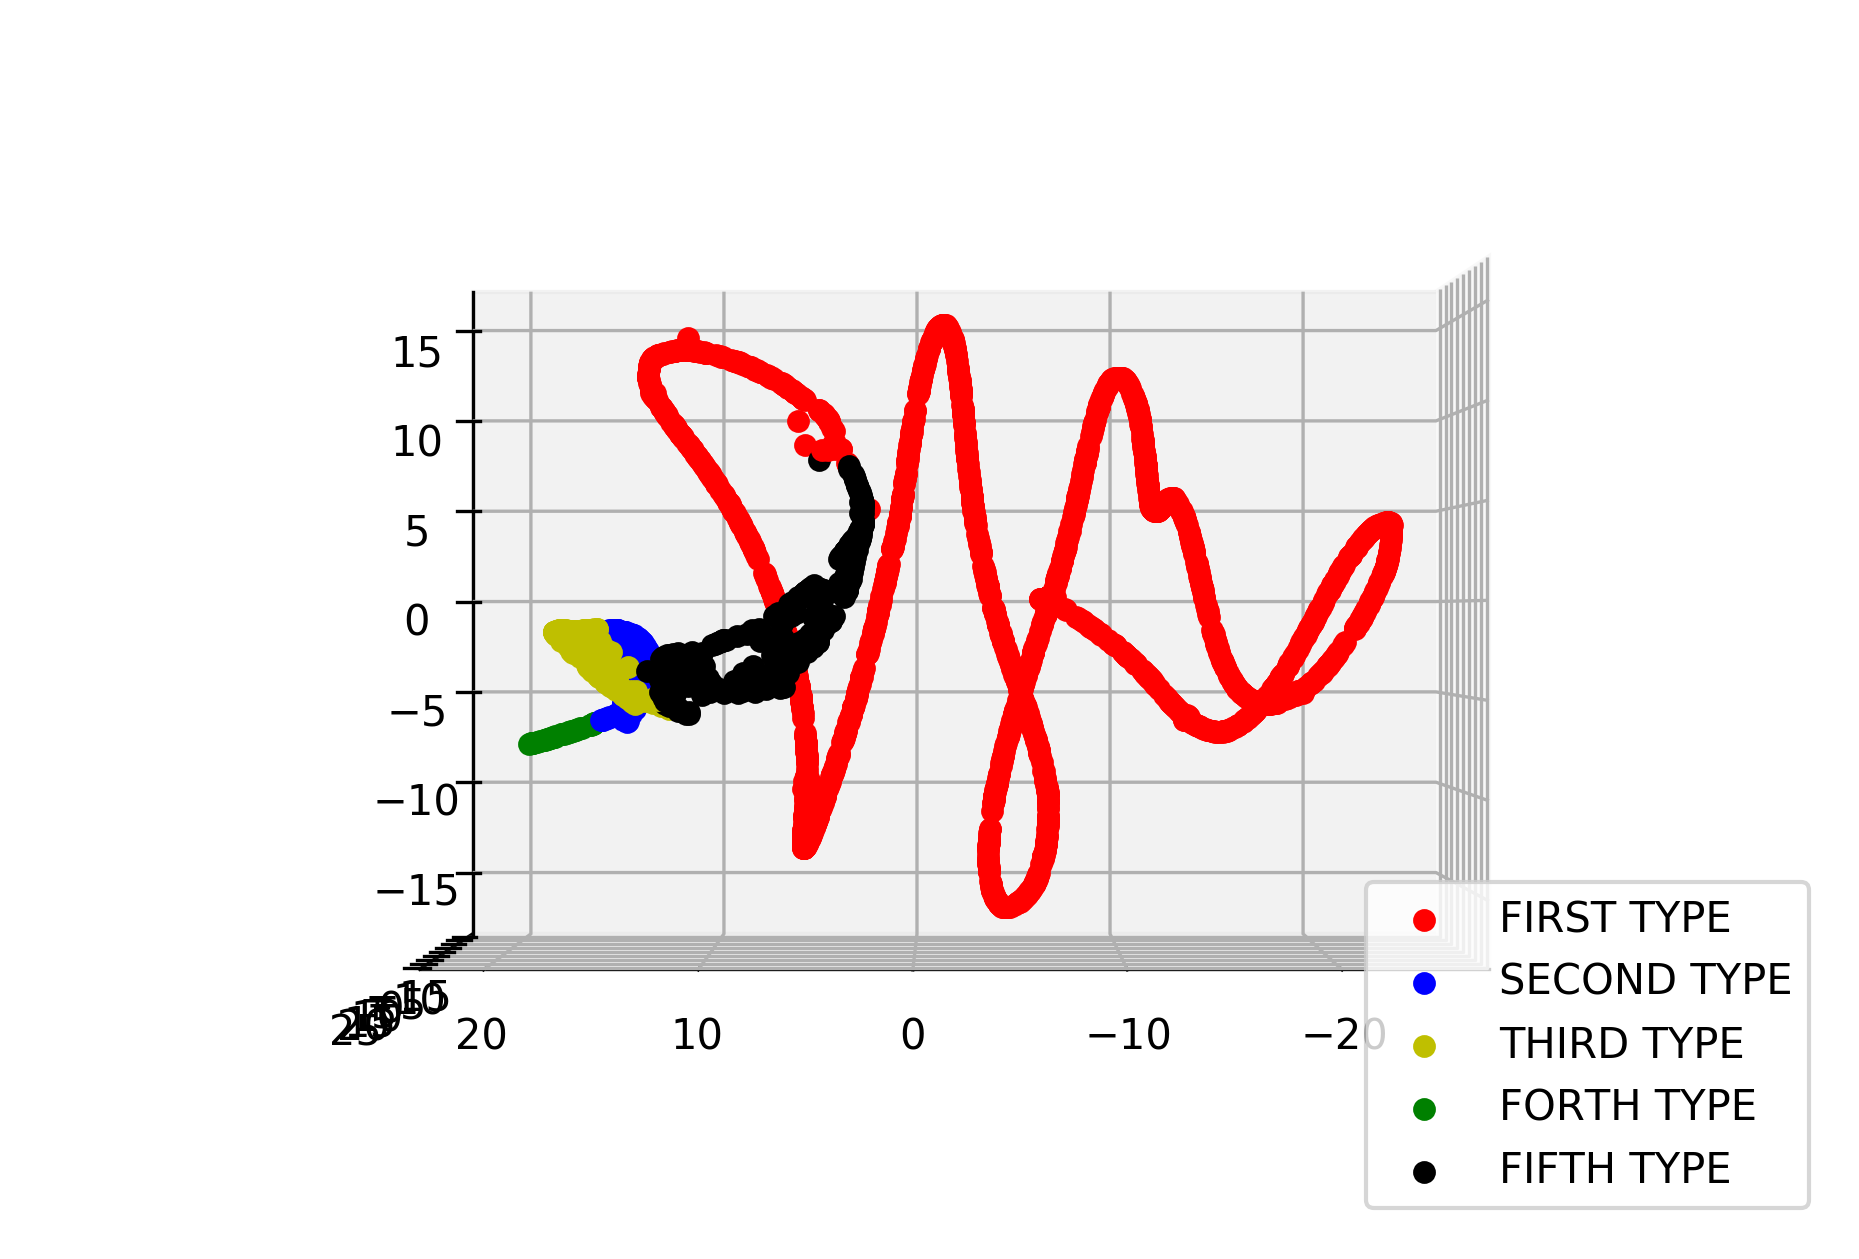

In [17]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
import math
import matplotlib.pyplot as plt


# 此处fig是二维
fig = plt.figure()
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300
# 将二维转化为三维
axes3d = Axes3D(fig)
axes3d.view_init(elev=0,azim=90)

for i in range (y_pre.shape[0]):
  if y_pre[i] == 0:
    point1=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='r')
  if y_pre[i] == 1:
    point2=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='b')
  if y_pre[i] == 2:
    point3=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='y')
  if y_pre[i] == 3:
    point4=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='g')
  if y_pre[i] == 4:
    point5=axes3d.scatter(re3d[i,0],re3d[i,1],re3d[i,2],c ='#000000')

plt.legend([point1,point2, point3,point4,point5], ['FIRST TYPE','SECOND TYPE','THIRD TYPE','FORTH TYPE','FIFTH TYPE'], loc='lower right', scatterpoints=1)




In [18]:
import torch
PATH= "/content/drive/My Drive/result/lracnpara.pth"
torch.save(net.state_dict(),PATH)

FileNotFoundError: ignored

In [0]:
'''
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
from torch.nn import init
widthof = 35739
lengthof = 2302
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder = nn.Sequential(
                nn.Linear(widthof,8000),
                nn.ReLU(),
                nn.Linear(8000,2000),
                nn.ReLU(),
                nn.Linear(2000,500),
                nn.ReLU(),
                nn.Linear(500,125),
                nn.ReLU(),
                nn.Linear(125,50),
                nn.ReLU(),
                nn.Linear(50,25),
                nn.ReLU(),
                nn.Linear(25,10)
                )

        self.decoder = nn.Sequential(
                nn.Linear(10,25),
                nn.ReLU(),
                nn.Linear(25,50),
                nn.ReLU(),
                nn.Linear(50,125),
                nn.ReLU(),
                nn.Linear(125,500),
                nn.ReLU(),
                nn.Linear(500,2000),
                nn.ReLU(),
                nn.Linear(2000,8000),
                nn.ReLU(),
                nn.Linear(8000,widthof),
                nn.Tanh()
                )
    def forward(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode,decode
      '''


In [0]:
'''import numpy as np
print(np.identity(10))

code = 1.0*np.identity(10)
code = Variable(torch.FloatTensor(code)).cuda() 
decode10 = net.decoder(code)
decode10 = decode10.cpu()
decode10 = decode10.data.numpy()
decode10 = decode10*293.438534039318+103.29597672711
'''